

**Problem Statement:**

Goal: Create a unified hybrid framework that adapts to the commodity type and automatically selects or combines the best models accordingly.

We loaded historical data from 2003-April 2025 alonmg with new realtime data to predict price with pre trained model.

## Step 8 Processing Real Time Data with Pre Trained Models

##### Sourcing Key Libraries


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : '../../Data/Historical_Gold_data_April_2015.csv',
           'SILVER': '../../Data/Historical_Silver_data_April_2015.csv',
           'CRUDE_OIL': '../../Data/Historical_Crude_oil_data_April_2015.csv',}

Live_Sentiments_file_name = 'real-Live_Sentiments.csv'
Live_Sentiments_file_dir = '../../Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = '../../Sentiments'

best_models_dir = {'GOLD': '../../Models/GOLD_MODELS', 'SILVER' : '../../Models/SILVER_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [3]:
commodity = input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')

Enter the Commodity Name CRUDE_OIL


Loading from Historical file id Data available in file : ../../Data/Historical_Crude_oil_data_April_2015.csv
Ticker code for CRUDE_OIL : CL=F


In [4]:
d = '30' #input('Enter the number of Days/Hours you eant to predict from real time 30,15,90')
days = int(d)
realtimedays = d+'d'
realtimedays

'30d'

## Data Sourcing

### Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [5]:
# Function to download historical price data
def download_price_data(ticker, start='2003-01-01', end='2025-04-05'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [60]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : ../../Data/Historical_Crude_oil_data_April_2015.csv
Ticker code for CRUDE_OIL : CL=F


### Fetch Realtime Data

In [61]:
# Function to fetch real-time data
def fetch_real_time_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    data.columns.name = None
    data.index = pd.to_datetime(data.index).date
    # Select and standardize the required columns
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

### Merge Historical Data with Realtime Data

In [62]:

real_time_data = fetch_real_time_data(ticker, period=realtimedays, interval='1h')
# Convert index to Date column
real_time_data['Date'] = real_time_data.index
# Reset index
real_time_data.reset_index(drop=True, inplace=True)
# Ensure 'Date' is datetime without timezone
real_time_data['Date'] = pd.to_datetime(real_time_data['Date']).dt.normalize()
# Reorder columns
real_time_data = real_time_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Print output
print(real_time_data.head())
# ######## Combine Real TIme data with Historical data
commodity_data = pd.concat([commodity_data,real_time_data])
commodity_data = commodity_data.drop_duplicates(subset='Date', keep='first')

[*********************100%***********************]  1 of 1 completed

        Date       Open       High        Low      Close  Volume
0 2025-03-28  69.919998  69.919998  69.720001  69.809998       0
1 2025-03-28  69.800003  69.830002  69.639999  69.720001    2054
2 2025-03-28  69.739998  69.879997  69.720001  69.779999    1381
3 2025-03-28  69.769997  69.769997  69.529999  69.559998    3658
4 2025-03-28  69.570000  69.919998  69.550003  69.910004    7246


In [63]:
commodity_data


,Date,Open,High,Low,Close,Volume
0,2015-01-02,53.759998,55.110001,52.029999,52.689999,268708
1,2015-01-05,52.610001,52.730000,49.680000,50.040001,375782
2,2015-01-06,50.000000,50.369999,47.549999,47.930000,451642
3,2015-01-07,48.000000,49.310001,46.830002,48.650002,460083
4,2015-01-08,48.779999,49.650002,47.730000,48.790001,362081
...,...,...,...,...,...,...
441,2025-04-28,63.110001,63.270000,63.070000,63.160000,1785
464,2025-04-29,62.009998,62.020000,61.779999,61.869999,3443
487,2025-04-30,60.279999,60.330002,60.200001,60.250000,3917
510,2025-05-01,58.369999,58.430000,58.209999,58.250000,2119


### Sourcing Market data

####  GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [64]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2024'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [65]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2024-01-01,NaT
1,2024-01-02,NaT
2,2024-01-03,NaT
3,2024-01-04,NaT
4,2024-01-05,NaT
...,...,...
677,2003-01-27,11456450000000.0
678,2003-01-28,11456450000000.0
679,2003-01-29,11456450000000.0
680,2003-01-30,11456450000000.0


####  Interest rate data

In [66]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19356\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25838,2025-03-28,4.33
25839,2025-03-29,4.33
25840,2025-03-30,4.33
25841,2025-03-31,4.33


####  GDP to Debt data

In [67]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


####  Inflation data

In [68]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33


####  ETF data

In [69]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2024-11-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'observation_start': '2003-01-01', 'observation_end': '2024-11-01', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'd

## Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [70]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta

# Set up NewsAPI
API_KEY = "250e051931514de6b0e5120412c4e3ad"
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Fetch news using query
def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
        "sortBy": "publishedAt",
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Load FinBERT pipeline
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Combined sentiment fetcher for crude oil-related queries
def get_oil_sentiment():
    queries = [
    "crude oil",
    "Brent crude",
    "WTI",
    "oil price",
    "oil futures",
    "oil market",
    "oil production",
    "OPEC",
    "oil demand"
]
    all_articles = []

    for query in queries:
        articles = fetch_news(query)
        all_articles.extend(articles)

    if not all_articles:
        return pd.DataFrame()

    df = pd.DataFrame(all_articles, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("oil_sentiment_data.csv", index=False)
    return df


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


#### Apply Sentiment analysis on Live data and save them in disk

In [71]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
    # sentiment_df = get_oil_sentiment()
    # sentiment_df.to_csv(Live_Sentiments_file, index=False)
    sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_oil_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-05-02T09:03:05Z  Mariner LLC Lowers Holdings in Cenovus Energy ...   
1  2025-05-02T08:58:49Z  Raymond James Financial Inc. Purchases Shares ...   
2  2025-05-02T08:54:47Z  Q4 EPS Estimates for Enbridge Lowered by US Ca...   
3  2025-05-02T08:38:00Z  Sarawak accuses Petronas arm of operating with...   
4  2025-05-02T08:30:52Z  Marshall Wace LLP Has $768,000 Holdings in Kin...   

  Sentiment  
0  negative  
1   neutral  
2  negative  
3  negative  
4   neutral  
                   Date                                           Headline  \
0  2025-05-02T09:03:05Z  Mariner LLC Lowers Holdings in Cenovus Energy ...   
1  2025-05-02T08:58:49Z  Raymond James Financial Inc. Purchases Shares ...   
2  2025-05-02T08:54:47Z  Q4 EPS Estimates for Enbridge Lowered by US Ca...   
3  2025-05-02T08:38:00Z  Sarawak accuses Petronas arm of operating with...   
4  2025-05-02T08:30:52Z  Marshall Wace LLP Has $768,000 H

,Date,Headline,Sentiment,Sentiment_score
0,2025-05-02,Mariner LLC Lowers Holdings in Cenovus Energy ...,negative,-1
1,2025-05-02,Raymond James Financial Inc. Purchases Shares ...,neutral,0
2,2025-05-02,Q4 EPS Estimates for Enbridge Lowered by US Ca...,negative,-1
3,2025-05-02,Sarawak accuses Petronas arm of operating with...,negative,-1
4,2025-05-02,"Marshall Wace LLP Has $768,000 Holdings in Kin...",neutral,0


#### Load Historical Sentiment data

In [72]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [73]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [74]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [75]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [76]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2603 non-null   object 
 1   Open            2603 non-null   float64
 2   High            2603 non-null   float64
 3   Low             2603 non-null   float64
 4   Close           2603 non-null   float64
 5   Volume          2603 non-null   int64  
 6   GDP             181 non-null    object 
 7   Interest_rates  81 non-null     float64
 8   Inflation_rate  81 non-null     float64
 9   DebtToGDP       2012 non-null   float64
 10  ETF_Value       51 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 223.8+ KB
Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
GDP               2422
Interest_rates    2522
Inflation_rate    2522
DebtToGDP          591
ETF_Value     

### 2.4 Processing NULL values from merged data

In [77]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

#  Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation
    merged_data[col].fillna(0, inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19356\3625551758.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19356\3625551758.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\

### Outlier Treatment

In [78]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
1330,2020-04-20,17.730000,17.850000,-40.320000,-37.630001,247947,2.195852e+13,1.815679,1.815679,124.733177,1.377451
1331,2020-04-21,-14.000000,13.860000,-16.740000,10.010000,2288230,2.195852e+13,1.815679,1.815679,124.733177,1.377451
1803,2022-03-04,107.959999,116.019997,107.250000,115.680000,493875,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1804,2022-03-07,121.330002,130.500000,115.540001,119.400002,576022,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1805,2022-03-08,120.669998,129.440002,117.070000,123.699997,583106,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1814,2022-03-21,105.129997,112.690002,104.080002,112.120003,77217,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1815,2022-03-22,112.900002,115.010002,109.300003,111.760002,318629,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1816,2022-03-23,108.849998,115.400002,108.379997,114.930000,289182,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1817,2022-03-24,114.470001,116.639999,110.610001,112.339996,307238,2.195852e+13,1.815679,1.815679,110.385332,1.377451
1818,2022-03-25,111.750000,114.120003,108.680000,113.900002,320304,2.195852e+13,1.815679,1.815679,110.385332,1.377451


In [79]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2015-01-02,53.759998,55.110001,52.029999,52.689999,268708,1.829502e+13,1.815679,1.815679,95.956145,1.377451
1,2015-01-05,52.610001,52.730000,49.680000,50.040001,375782,1.829502e+13,1.815679,1.815679,95.956145,1.377451
2,2015-01-06,50.000000,50.369999,47.549999,47.930000,451642,1.829502e+13,1.815679,1.815679,95.956145,1.377451
3,2015-01-07,48.000000,49.310001,46.830002,48.650002,460083,1.829502e+13,1.815679,1.815679,95.956145,1.377451
4,2015-01-08,48.779999,49.650002,47.730000,48.790001,362081,1.829502e+13,1.815679,1.815679,95.956145,1.377451
...,...,...,...,...,...,...,...,...,...,...,...
2598,2025-04-28,63.110001,63.270000,63.070000,63.160000,1785,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2599,2025-04-29,62.009998,62.020000,61.779999,61.869999,3443,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2600,2025-04-30,60.279999,60.330002,60.200001,60.250000,3917,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2601,2025-05-01,58.369999,58.430000,58.209999,58.250000,2119,2.195852e+13,1.815679,1.815679,105.457564,1.377451


###  Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [80]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [81]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


           Date  Sentiment_score
1175 2025-04-23               -1
1176 2025-04-23               -1
292  2025-04-23               -1
291  2025-04-23               -1
1172 2025-04-24               -1


In [82]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [83]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
2598,2025-04-28,63.110001,63.270000,63.070000,63.160000,1785,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2599,2025-04-29,62.009998,62.020000,61.779999,61.869999,3443,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2600,2025-04-30,60.279999,60.330002,60.200001,60.250000,3917,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2601,2025-05-01,58.369999,58.430000,58.209999,58.250000,2119,2.195852e+13,1.815679,1.815679,105.457564,1.377451
2602,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,1.377451


### 2.8 Merging Sentiment Data with Gold Data

In [84]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2015-01-02,53.759998,55.110001,52.029999,52.689999,268708,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
1,2015-01-05,52.610001,52.730000,49.680000,50.040001,375782,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
2,2015-01-06,50.000000,50.369999,47.549999,47.930000,451642,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
3,2015-01-07,48.000000,49.310001,46.830002,48.650002,460083,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
4,2015-01-08,48.779999,49.650002,47.730000,48.790001,362081,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN


In [85]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
-1.0    702
 0.0    690
 1.0    362
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [86]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19356\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [87]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    3284
-1.0     702
 1.0     362
Name: count, dtype: int64

In [88]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2015-01-02,53.759998,55.110001,52.029999,52.689999,268708,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
1,2015-01-05,52.610001,52.730000,49.680000,50.040001,375782,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0.0
2,2015-01-06,50.000000,50.369999,47.549999,47.930000,451642,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
3,2015-01-07,48.000000,49.310001,46.830002,48.650002,460083,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
4,2015-01-08,48.779999,49.650002,47.730000,48.790001,362081,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4343,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,1.377451,0.0
4344,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,1.377451,0.0
4345,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,1.377451,0.0
4346,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,1.377451,0.0


## Step 3 : Feature Engineering

### 4.1 Create Features 

In [89]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()

    return df


### 4.2 Apply Feature engineering on data

In [90]:
commodity_data = feature_engineering(commodity_data)

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [91]:
feature_engineering(commodity_data)

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
0,2015-01-02,53.759998,55.110001,52.029999,52.689999,268708,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,50.040001,NaN,NaN,NaN,-1.000000,-1.000000
1,2015-01-05,52.610001,52.730000,49.680000,50.040001,375782,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,47.930000,-0.051603,NaN,NaN,-0.500000,-0.500000
2,2015-01-06,50.000000,50.369999,47.549999,47.930000,451642,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,48.650002,-0.043081,NaN,NaN,-0.666667,-0.666667
3,2015-01-07,48.000000,49.310001,46.830002,48.650002,460083,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,48.790001,0.014910,NaN,NaN,-0.750000,-0.750000
4,2015-01-08,48.779999,49.650002,47.730000,48.790001,362081,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,48.360001,0.002874,NaN,NaN,-0.600000,-0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4343,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,...,59.48,59.48,59.48,59.48,59.480000,0.000000,0.0,0.0,0.000000,0.000000
4344,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,...,59.48,59.48,59.48,59.48,59.480000,0.000000,0.0,0.0,0.000000,0.000000
4345,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,...,59.48,59.48,59.48,59.48,59.480000,0.000000,0.0,0.0,0.000000,0.000000
4346,2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,...,59.48,59.48,59.48,59.48,59.480000,0.000000,0.0,0.0,0.000000,0.000000


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
Low,0.997760
High,0.995699
Open,0.994215
tomorrow_price,0.992832
lag_1,0.992832
MA_7,0.991665
lag_7,0.971899
MA_30,0.966191
MA_90,0.901031


### 4.3 Seting Index of data frame is as a Date column

In [93]:
commodity_data_df = commodity_data
commodity_data_df = commodity_data_df.drop_duplicates(subset='Date', keep='first')
commodity_data_df.set_index('Date', drop=True, inplace=True)
commodity_data_df = commodity_data_df.fillna(0.0)

In [94]:
commodity_data_df.tail()

,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,63.110001,63.270000,63.070000,63.160000,1785,2.195852e+13,1.815679,1.815679,105.457564,1.377451,...,63.020000,63.102858,63.149000,63.487334,63.160000,-0.003477,0.853419,1.388276,0.0,0.0
2025-04-29,62.009998,62.020000,61.779999,61.869999,3443,2.195852e+13,1.815679,1.815679,105.457564,1.377451,...,63.160000,62.975714,63.117000,63.145667,61.869999,-0.020636,0.487575,0.235521,0.0,0.0
2025-04-30,60.279999,60.330002,60.200001,60.250000,3917,2.195852e+13,1.815679,1.815679,105.457564,1.377451,...,61.869999,61.638571,61.815999,61.851999,60.250000,-0.026533,0.612302,0.295770,0.0,0.0
2025-05-01,58.369999,58.430000,58.209999,58.250000,2119,2.195852e+13,1.815679,1.815679,105.457564,1.377451,...,60.250000,59.964286,60.183333,60.227778,58.250000,-0.033758,0.755929,0.365148,0.0,0.0
2025-05-02,58.919998,59.500000,58.910000,59.480000,4712,2.195852e+13,1.815679,1.815679,105.457564,1.377451,...,58.250000,58.425714,58.291000,58.263667,59.480000,0.020896,0.464896,0.224566,0.0,0.0


### Step 5 Data Split and Scaling

In [95]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.95) 
# split_date =  pd.to_datetime('2022-01-01')
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (2473, 23), Test size: (131, 23)


In [96]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=[ 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['Close'])
y_test = test_df['Close']
 

In [97]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()


In [98]:
# # Define the model directory
# model_dir = hybrid_models_dir.get(commodity.upper())

# # Define the model directory
# meta_dir = hybrid_meta_models_dir.get(commodity.upper())
# hybridmodel_name = 'meta_model_'+commodity+'.pkl'
# hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# # Load the meta-model (used in stacked hybrid)
# with open(hybrid_meta_model_name, 'rb') as f:
#     meta_model = pickle.load(f)


In [99]:
# # Function to load models
# def load_saved_models(directory):
#     model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
#     models = {}
#     for file in model_files:
#         model_path = os.path.join(directory, file)
#         model_name = file.replace(".pkl", "")
#         print(model_path)
#         model = joblib.load(model_path)
#         models[model_name] = model
#     return models

# # Load all saved models
# loaded_models = load_saved_models(model_dir)



### 8.1 Load pre trained model from File

In [100]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        model = model.fit(X_train_scaled_minmax, y_train_scaled)
        xgb_predictions = model.predict(X_test_scaled_minmax)
        xgb_prediction = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        y_test_org = scaler_minmax.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
        return scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()

    elif "RF" in model_name.upper():
        #  Remove Sentiment & Macroeconomic Features from Training Data
        exclude_columns = ['GDP', 'Interest_rates','Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'Sentiment_Rolling_14',
        'Sentiment_Rolling_30', 'Sentiment_smoothed']
        X_train_filtered = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore').fillna(0.0)
        X_test_filtered = pd.DataFrame(X_test_scaled_minmax, columns=X_test.columns).drop(columns=exclude_columns, errors='ignore').fillna(0.0)

        random_search = model.fit(X_train_filtered, y_train_scaled)
        y_pred_rf = random_search.predict(X_test_filtered)
        return  scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

    elif "LSTM" in model_name.upper():
        #  Select Sentiment + Microeconomic Features
        selected_features = [
            'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
            'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
            'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
        ]
        
        # Extract Features for Training & Testing
        X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
        X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values
        
        #  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
        look_back = 14  # Using the same look-back period
        
        def create_sequences(X, y, look_back):
            Xs, ys = [], []
            for i in range(len(X) - look_back):
                Xs.append(X[i:i + look_back])
                ys.append(y[i + look_back])
            return np.array(Xs), np.array(ys)
        
        X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
        X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)
        #  Train Model
        model = model.fit(
            X_train_seq, y_train_seq,
            epochs=50, batch_size=32, 
            validation_data=(X_test_seq, y_test_seq),
            verbose=1
        )
        
        #  Predict on Test Set
        y_pred_lstm_scaled = model.predict(X_test_seq)
        
        #  Inverse Transform Predictions to Original Scale
        y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)
        return y_pred_lstm_original

    elif "ARIMA" in model_name.upper(): 
        # Select microeconomic factors from the scaled data
        exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]
        exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]
        model2 = model.get_forecast(steps=len(y_test), exog=exog_test)
        fc_model2 = model2.predicted_mean
        return fc_model2.values
        
    elif "GARCH" in model_name.upper():
        y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
        y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()
        garch_forecast = model.forecast(horizon=len(y_test_log_returns))
        garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()
        # Convert forecasted log returns back to price predictions
        y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
        garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))
        return garch_predicted_prices
        
    elif "VAR" in model_name.upper():
        # Ensure data is stationary (apply differencing)
        train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                              'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                            'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        
        # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
        test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
        
        # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
        # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
        
        # Select optimal lag using BIC
        var_model = VAR(endog=train_var, exog=train_exog)
        lag_selection = var_model.select_order(maxlags=15)
        optimal_lag = lag_selection.bic
        print(f"Optimal lag order (BIC): {optimal_lag}")
        
        # Fit VAR model
        var_fitted = var_model.fit(optimal_lag)
        
        # Forecast
        forecast_steps = len(test_var)
        last_observations = train_var.values[-optimal_lag:]
        
        # Forecast with exogenous variables
        var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
        
        # Convert forecasted differenced values back to original scale
        forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
        forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
        
        # Extract predicted Close prices
        predicted_prices = forecast_df_m4['Close']
        return predicted_prices
    else:
        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_d= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_d[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: RF_best-2
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Predicted values: [69.25       70.0897901  71.62333171 72.38499832 70.05947434 72.22371125
 70.05947434 68.61333211 68.86399994 68.21750069 68.86399994 67.08250046
 68.46666718 69.03399963 69.20999908 70.50499916 71.09000206 69.20999908
 69.96399994 68.86399994 68.22599945 68.86399994 69.96399994 68.22599945
 68.22599945 67.54000092 68.21750069 68.86399994 69.96399994 69.3945619
 71.09000206 70.76749992 70.36249924 70.36249924 69.74500275 68.22599945
 68.22599945 69.74500275 69.74500275 69.74500275 69.74500275 72.26751762
 72.95400238 74.07200165 74.18800049 74.07200165 73.33037973 73.48500061
 77.25       78.47528127 78.14500046 80.01638785 79.09749985 78.14500046
 76.15666707 75.61199951 74.66199951 74.66199951 72.92600098 73.08333333
 73.09999847 72.42749977 72.42749977 73.85333252 71.21250153 71.54599915
 70.76749992 70.91999817 72.33322716 73.33600006 71.91999969 71.45999908
 70.76749992 71.8        72.35       73.33600006 70.90500259 70.65666453
 69.20999908 68.56666819 70.169998

### 8.2 Load Pretrained Hybrid Model

In [101]:
#stacking

from sklearn.linear_model import LinearRegression
best1_forecast_trimmed,best2_forecast_trimmed = list(predict_d.values())
# Create a new dataset with ARIMA and XGBoost predictions
X_combined = np.column_stack([best2_forecast_trimmed,best1_forecast_trimmed])
# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Final predictions from the hybrid model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)

# Create a new dataset with ARIMA and XGBoost predictions
X_combined = np.column_stack(list(predict_d.values()))
# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Final predictions from the hybrid model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


### 8.3 Predict Price with Stacked Hybrid Model

In [102]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 1 # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-05-03          69.3163


### 8.4 Let's verify Price with Weighted Hybrid Model

In [103]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
min_length = min(len(best1_forecast_trimmed),len(best2_forecast_trimmed))
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)



### 8.5 Predict Price with Weighted Hybrid Model

In [104]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Weighted': hybrid_weighted_future,
}, index=future_dates)
print(future_price)

            Hybrid_Weighted
2025-05-03        59.469706


### 8.6 Future Price Prediction and recommendation to Buy or Sell

In [105]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 10  # Number of future predictions
threshold = 0.5  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price Weighted': hybrid_predictions_weighted,
    'Future Price Stacked': hybrid_predictions_stacked,
    'Future Price Average': hybrid_predictions_average
}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Weighted Hybrid
recommendation = []
for forecast in hybrid_predictions_weighted:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    return 100 - mape(y_true, y_pred)

# Custom metrics
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    return 100 - mape(y_true, y_pred)

def me(y_true, y_pred):
    return np.mean(y_pred - y_true)

# Store all evaluation metrics
metrics_summary = {
    "Model": ["Average Hybrid", "Weighted Hybrid", "Stacked Hybrid"],
    
    "ME": [
        me(actual_values, hybrid_predictions_average),
        me(actual_values, hybrid_predictions_weighted),
        me(actual_values, hybrid_predictions_stacked)
    ],
    "MSE": [
        mean_squared_error(actual_values, hybrid_predictions_average),
        mean_squared_error(actual_values, hybrid_predictions_weighted),
        mean_squared_error(actual_values, hybrid_predictions_stacked)
    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_average),
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_average)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked))
    ],
    "R² Score": [
        r2_score(actual_values, hybrid_predictions_average),
        r2_score(actual_values, hybrid_predictions_weighted),
        r2_score(actual_values, hybrid_predictions_stacked)
    ],
    "MAPE (%)": [
        mape(actual_values, hybrid_predictions_average),
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked)
    ],
    "Accuracy (%)": [
        accuracy(actual_values, hybrid_predictions_average),
        accuracy(actual_values, hybrid_predictions_weighted),
        accuracy(actual_values, hybrid_predictions_stacked)
    ]
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print("\nEvaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\nEvaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 59.48

Predicted future values and investment recommendation:
            Future Price Weighted  Future Price Stacked  Future Price Average  \
2025-05-03              70.615196             83.786711             70.586236   
2025-05-04              59.212262             69.321383             59.169621   
2025-05-05              62.293582             73.440185             62.293297   
2025-05-06              64.929579             76.145871             64.814939   
2025-05-07              63.315631             74.962621             63.358170   
2025-05-08              63.063014             73.831899             62.956054   
2025-05-09              62.171599             73.979116             62.298896   
2025-05-10              59.812017             69.222334             59.611765   
2025-05-11              58.503684             69.072093             58.579801   
2025-05-12              59.469706             69.316300             59.366304   

           Recomme

## Real Time Prediction Conclusion

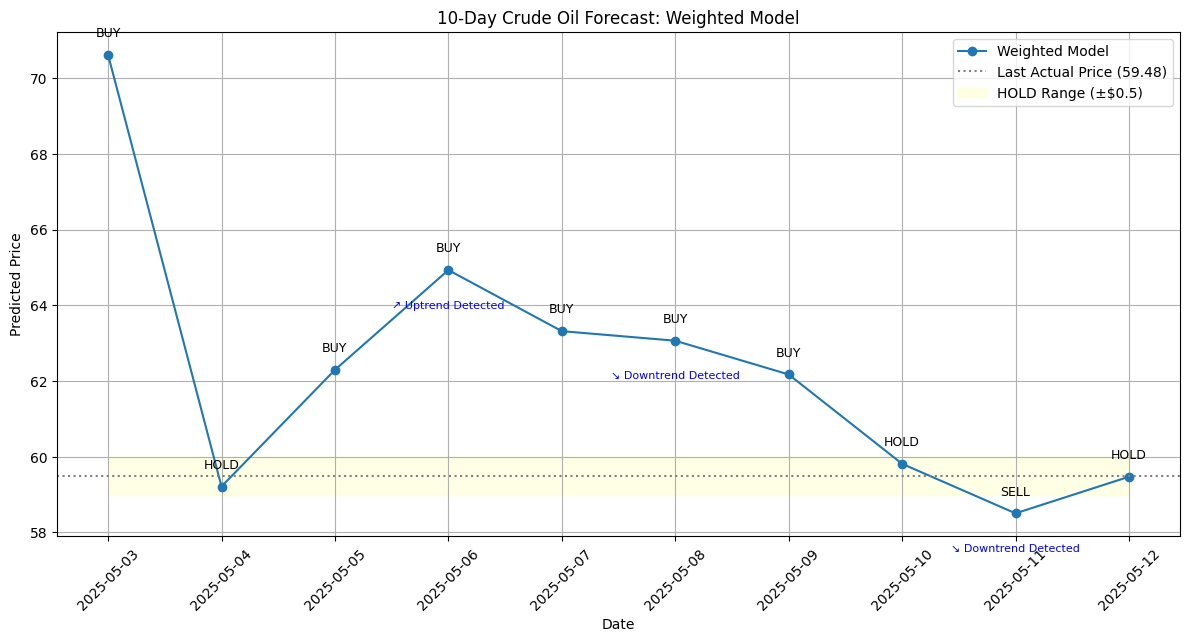

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
n = 10  # Number of future predictions (default: 5 days)2
threshold = 0.5  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price weighted': hybrid_weighted_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_weighted_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY")
    elif diff < -threshold:
        recommendations.append("SELL")
    else:
        recommendations.append("HOLD")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend

# === Plot Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price weighted'], label='Weighted Model', marker='o')

plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$0.5)')
plt.title("10-Day Crude Oil Forecast: Weighted Model")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

# === Add Annotations with Boundary-Aware Positioning ===
ymin, ymax = plt.ylim()
text_offset = (ymax - ymin) * 0.03  # dynamic offset ~3% of range

for x, y, rec, sig in zip(future_price.index, 
                          future_price['Future Price weighted'], 
                          future_price['Recommendation'], 
                          future_price['Signal']):
    # Calculate safe y-position for text (avoid going above ymax)
    y_text = y + text_offset
    if y_text > ymax:
        y_text = y - text_offset * 2  # put below if too high

    plt.text(x, y_text, rec, fontsize=9, ha='center', va='bottom')

    # Optional: show signal trend below the point
    if sig:
        plt.text(x, y - text_offset * 2, sig, fontsize=8, ha='center', va='top', color='blue')

# Optional: Rotate x-axis labels
plt.xticks(rotation=45)


plt.show()



In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n = 24 # Number of future predictions
threshold = 0.2  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
# Ensure future dates are hourly starting from the last actual date in y_test
last_actual_date = y_test.index[-1]  # Get the last date from y_test
future_dates = pd.date_range(start=last_actual_date, periods=n, freq='H')  # Hourly frequency
future_price = pd.DataFrame({
    'Future Price Weighted': hybrid_weighted_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_weighted_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY")
    elif diff < -threshold:
        recommendations.append("SELL")
    else:
        recommendations.append("HOLD")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend



future_price

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19356\1912586650.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_actual_date, periods=n, freq='H')  # Hourly frequency


,Future Price Weighted,Recommendation,Signal
2025-05-02 00:00:00,60.535511,BUY,
2025-05-02 01:00:00,59.458244,HOLD,
2025-05-02 02:00:00,59.392226,HOLD,↘️ Downtrend Detected
2025-05-02 03:00:00,59.962746,BUY,
2025-05-02 04:00:00,61.623939,BUY,↗️ Uptrend Detected
2025-05-02 05:00:00,61.337084,BUY,
2025-05-02 06:00:00,61.733156,BUY,
2025-05-02 07:00:00,61.885092,BUY,
2025-05-02 08:00:00,64.125535,BUY,
2025-05-02 09:00:00,63.017040,BUY,


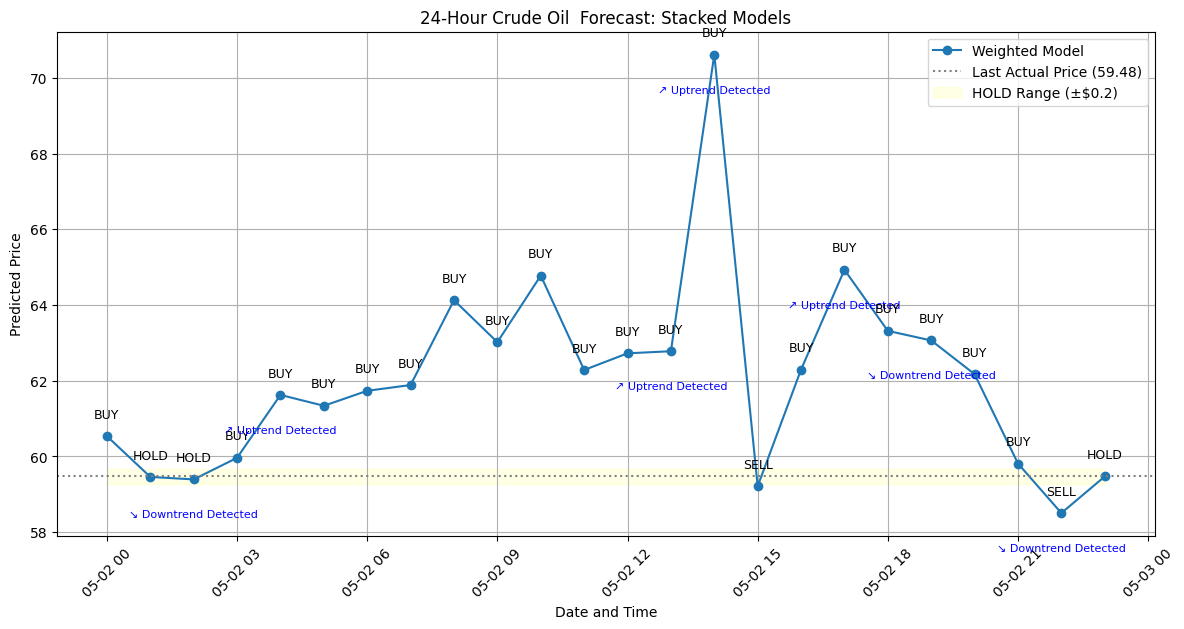

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price Weighted'], label='Weighted Model', marker='o')

plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$0.2)')
plt.title(f"{n}-Hour Crude Oil  Forecast: Stacked Models")
plt.xlabel("Date and Time")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

# === Add Annotations with Boundary-Aware Positioning ===
ymin, ymax = plt.ylim()
text_offset = (ymax - ymin) * 0.03  # dynamic offset ~3% of range

for x, y, rec, sig in zip(future_price.index, 
                          future_price['Future Price Weighted'], 
                          future_price['Recommendation'], 
                          future_price['Signal']):
    # Calculate safe y-position for text (avoid going above ymax)
    y_text = y + text_offset
    if y_text > ymax:
        y_text = y - text_offset * 2  # put below if too high

    plt.text(x, y_text, rec, fontsize=9, ha='center', va='bottom')

    # Optional: show signal trend below the point
    if sig:
        plt.text(x, y - text_offset * 2, sig, fontsize=8, ha='center', va='top', color='blue')

# Optional: Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()
